
    Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

    *вариант для 1) Обучите VAE на fashion_mnist 

In [127]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [128]:
torch.manual_seed(3)
BATCH_SIZE = 64
NUMBER_OF_EPOCH = 8

device = torch.device("cuda")

kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('/./FashionMNIST', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('/./FashionMNIST', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)


In [129]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc31 = nn.Linear(400, 20)
        self.fc32 = nn.Linear(400, 20)
        self.fc4 = nn.Linear(20, 400)
        self.fc5 = nn.Linear(400, 400)
        self.fc6 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc2(h1))
        return self.fc31(h1), self.fc32(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h3 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [130]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [131]:

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        LOG_INTERVALS = 300
        if batch_idx % LOG_INTERVALS == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [132]:
losses = []
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         f'./reconstruction_{epoch}.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    losses.append(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [133]:
print(device)
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


cuda


In [134]:
if __name__ == "__main__":
    torch.manual_seed(45)
    for epoch in range(1, NUMBER_OF_EPOCH+1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       f'./sample_{epoch}.png')
            


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.266785
Train Epoch: 1 [19200/60000 (32%)]	Loss: 273.523407
Train Epoch: 1 [38400/60000 (64%)]	Loss: 253.318069
Train Epoch: 1 [57600/60000 (96%)]	Loss: 258.089264
====> Epoch: 1 Average loss: 277.0039
====> Test set loss: 255.4236
Train Epoch: 2 [0/60000 (0%)]	Loss: 266.746765
Train Epoch: 2 [19200/60000 (32%)]	Loss: 251.914169
Train Epoch: 2 [38400/60000 (64%)]	Loss: 242.133163
Train Epoch: 2 [57600/60000 (96%)]	Loss: 241.057800
====> Epoch: 2 Average loss: 250.0366
====> Test set loss: 249.0271
Train Epoch: 3 [0/60000 (0%)]	Loss: 244.056519
Train Epoch: 3 [19200/60000 (32%)]	Loss: 237.456100
Train Epoch: 3 [38400/60000 (64%)]	Loss: 248.193069
Train Epoch: 3 [57600/60000 (96%)]	Loss: 239.108261
====> Epoch: 3 Average loss: 246.4576
====> Test set loss: 246.8240
Train Epoch: 4 [0/60000 (0%)]	Loss: 249.401581
Train Epoch: 4 [19200/60000 (32%)]	Loss: 256.097900
Train Epoch: 4 [38400/60000 (64%)]	Loss: 235.814743
Train Epoch: 4 [57600/60000 (96%)]	L

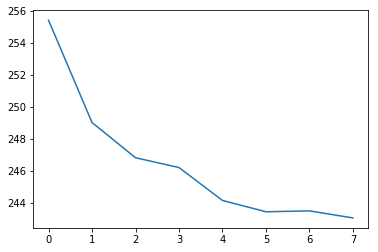

In [136]:
    plt.plot(losses)
    plt.show()

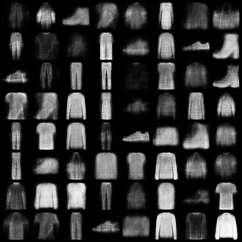

In [137]:
from IPython.display import Image 
Image(filename='/vae_fashionMNIST/sample_1.png')



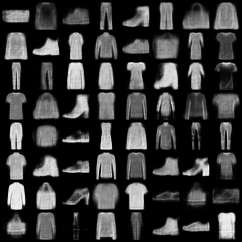

In [138]:
Image(filename='/vae_fashionMNIST/sample_8.png')



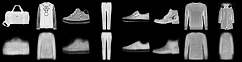

In [139]:
Image(filename='/vae_fashionMNIST/reconstruction_8.png')